**Option 2:**

Biodiversity Intactness Index change in Phoenix subdivision
Context
In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001 [1]. Urban sprawl creates pressure on biodiversity and natural areas. In this task you will explore a dataset showing values for a biodiversity intactness index (BII) [2, 3] to find changes in this BII around the Phoenix area from 2017 to 2020.

SETUP 

First, read all the instructions. Choose an adequate, informative title for a new repository containing the notebook for this task (not EDS220-final-project). 
Create a new GitHub repository and clone it into the Microsoft Planetary Computer. 


1. Data access:
BII data: This dataset is part of the MPC STAC catalog. You will need to access the ‘io-biodiversity’ collection and look for the 2017 and 2020 rasters covering Phoenix subdivision. You can use the following coordinates for a bounding box: 
[-112.826843, 32.974108, -111.184387, 33.863574]
Phoenix subdivision: You will find the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

2. Create a map showing the Phoenix subdivision within an appropriate geographical context. You may use any vector datasets to create your map. (You can also check out the contextily package.)

3. Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020.
HINTS (useful or not depending on your workflow): 
Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’. 
To calculate the percentage area: (pixels in class)/(total pixels) * 100. 

4. Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020. Here’s an example:


In [1]:
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

# ----- other libraries for nice ouputs
from IPython.display import Image
import contextily as ctx #basemaps


In [2]:
# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

AZ_shp = gpd.read_file("data/tl_2022_04_cousub")

# metadata from the catalog
#print('ID:', catalog.id)
print('Title:', catalog.title)
print('Description:', catalog.description)

#We can access its collections by using the get_collections() method:
catalog.get_collections()

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


<generator object Client.get_collections at 0x7c47a5a40260>

In [3]:
# get collections and print their names
collections = list(catalog.get_collections())

print('Number of collections:', len(collections))
print("Collections IDs:")
for collection in collections:
    print('-', collection.id)

Number of collections: 122
Collections IDs:
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi
- daymet-monthly-hi
- daymet-monthly-pr
- gnatsgo-tables
- hgb
- cop-dem-glo-30
- cop-dem-glo-90
- goes-cmi
- terraclimate
- nasa-nex-gddp-cmip6
- gpm-imerg-hhr
- gnatsgo-rasters
- 3dep-lidar-hag
- 3dep-lidar-intensity
- 3dep-lidar-pointsourceid
- mtbs
- noaa-c-cap
- 3dep-lidar-copc
- modis-64A1-061
- alos-fnf-mosaic
- 3dep-lidar-returns
- mobi
- landsat-c2-l2
- era5-pds
- chloris-biomass
- kaza-hydroforecast
- planet-nicfi-analytic
- modis-17A2H-061
- modis-11A2-061
- daymet-daily-pr
- 3dep-lidar-dtm-native
- 3dep-lidar-classification
- 3dep-lidar-dtm
- gap
- modis-17A2HGF-061
- planet-nicfi-visual
- gbif
- modis-17A3HGF-061
- modis-09A1-061
- alos-dem
- alos-palsar-mosaic
- deltares-water-availability
- modis-16A3GF-061
- modis-21A2-061
- us-census
- jrc-gsw
- deltares-floods
- modi

In [4]:
io_bio_collection = catalog.get_child('io-biodiversity')
io_bio_collection

id: io-biodiversity
title: Biodiversity Intactness
"description: Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. The approach differs from previous work by modeling the relationship between observed biodiversity metrics and contemporary, global, geospatial layers of human pressures, with the intention of providing a high resolution monitoring product into the future. Biodiversity intactness is estimated as a combination of two metrics: Abundance, the quantity of individuals, and Compositional Similarity, how similar the composition of species is to an intact baseline. Linear mixed effects models are fit to estimate the predictive capacity of spatial datasets of human pressures on each of these metrics and project results spatially across the globe. These methods, as well as comparisons to other leading datasets and guidance on interpreting results, are further explained in a methods [white paper](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf) entitled “Global 100m Projections of Biodiversity Intactness for the years 2017-2020.” All years are available under a Creative Commons BY-4.0 license."
"providers: Impact Observatory (processor, producer, licensor) Vizzuality (processor) Microsoft (host)"
type: Collection
"item_assets: {'data': {'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'Biodiversity Intactness', 'description': 'Terrestrial biodiversity intactness at 100m resolution', 'raster:bands': [{'sampling': 'area', 'data_type': 'float32', 'spatial_resolution': 100}]}}"
msft:region: westeurope
msft:container: impact
msft:storage_account: pcdata01euw
msft:short_description: Global terrestrial biodiversity intactness at 100m resolution for years 2017-2020
https://stac-extensions.github.io/item-assets/v1.0.0/schema.json


In [5]:
# Temporal range of interest
time_range= "2017-01-01/2020-12-31"

# NCEAS bounding box (as a GeoJSON)
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range) #datetime = 2017/2020
search

In [6]:

#[-112.826843, 32.974108, -111.184387, 33.863574]

items = search.item_collection()
items

# number of items in search
len(items)

#item_2017 = items[0]
#items_2020 = items[3]

4

In [7]:
# get first item in the catalog search
item_2017 = items[0]
type(item_2017)

# print item id and properties
print('id:' , item_2017.id)
item_2017.properties

item_2017.assets

for key in item_2017.assets.keys():
    print(key, '--', item_2017.assets[key].title)
    
# plot rendered preview
Image(url=item_2017.assets['rendered_preview'].href, width=500)

id: bii_2020_34.74464974521749_-115.38597824385106_cog
data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [8]:
## -------------------------------------------------------------------------#
# get fourth item in the catalog search
item_2020 = items[3]
type(item_2020)


# print item id and properties
print('id:' , item_2020.id)
item_2020.properties

item_2020.assets

for key in item_2020.assets.keys():
    print(key, '--', item_2020.assets[key].title)
    
# plot rendered preview
Image(url=item_2020.assets['rendered_preview'].href, width=500)

id: bii_2017_34.74464974521749_-115.38597824385106_cog
data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [9]:
AZ_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
AZ_2017

AZ_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
AZ_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Create a map showing the Phoenix subdivision within an appropriate geographical context. You may use any vector datasets to create your map. (You can also check out the contextily package.)

array(['Flagstaff', 'Kaibab Plateau', 'Hualapai', 'Nogales', 'Patagonia',
       'Hopi', 'Tuba City', 'Clifton', 'Duncan', 'Chandler', 'Phoenix',
       'Tonto National Forest', 'Gila Bend', 'Wickenburg', 'Deer Valley',
       'Buckeye', 'St. Johns', 'Salt River', 'Tucson', 'Arivaca',
       'Indian Wells', 'Winslow-Holbrook', 'Snowflake', 'Kayenta',
       'Lake Havasu City', 'Fort Apache', 'Bisbee', 'Bowie', 'Willcox',
       'North Mohave', 'Kingman', 'Bullhead City', 'Congress',
       'Mingus Mountain', 'Florence', 'North Pinal', 'San Manuel', 'Eloy',
       'Chinle', 'Fort Apache', 'Sweetwater', 'Fort Defiance',
       'Dennehotso', 'Puerco', 'Ash Fork', 'Cordes Lakes-Mayer',
       'Camp Verde-Sedona', 'Prescott', 'Hopi', 'Piñon', 'Fort Apache',
       'Payson', 'Winkelman', 'Globe-Miami', 'Tonto Basin', 'Gila River',
       'Casa Grande', 'Maricopa-Stanfield', "Tohono O'odham Nation",
       'Coolidge', 'Ajo', 'Marana', "Tohono O'odham Nation", 'Somerton',
       'Bonita-Klondy

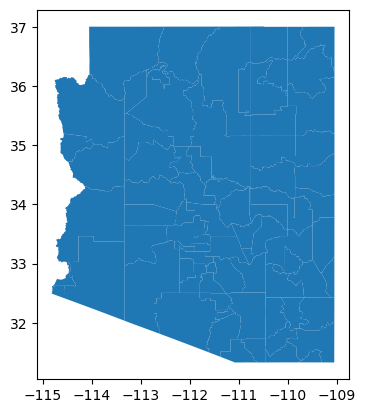

In [10]:
#clip to arizone shapefile
AZ_shp.plot()

AZ_shp.NAME.values

In [11]:
phx = AZ_shp[AZ_shp.NAME == "Phoenix"]

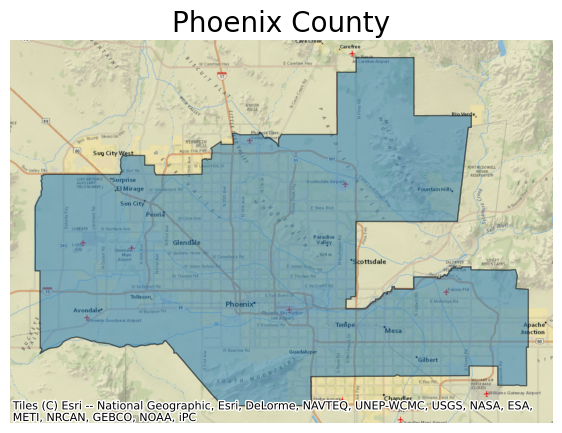

In [12]:
ax = (phx.to_crs(epsg=3857)
      .plot(figsize=(7,7),alpha=0.5, edgecolor="k")
     )
ctx.add_basemap(ax, source = ctx.providers.Esri.NatGeoWorldMap)
    
ax.set_title("Phoenix County", fontdict = {"fontsize":"20"})
ax.set_axis_off()

#### Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020. HINTS (useful or not depending on your workflow): Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’. To calculate the percentage area: (pixels in class)/(total pixels) * 100.

In [13]:
phx.crs = "epsg:4326"

phx.crs == AZ_2017.rio.crs

phx.head

clip_2017 = (AZ_2017.rio.clip(phx.geometry))
clip_2020 = (AZ_2020.rio.clip(phx.geometry))

In [14]:
greaterBII_2017 = (clip_2017 >= 0.75)

greaterBII_2020 = (clip_2020 >= 0.75)

greaterBII